# Chapter 3: synthetic data study
# Data Generation

<div class="alert alert-success">
    
This Notebook contains the Code to produce the synthetic data as well as figures of synthetic models and data.

In [11]:
# Importing pygimli
import  pygimli                    as     pg
import  pygimli.meshtools          as     mt
from    pygimli.physics            import ert
from    pygimli.physics            import TravelTimeManager
from    pygimli.physics.traveltime import createRAData
from    PlotFunctions_Ch4          import *

# Importing auxiliary libraries
import  numpy                      as     np
import  pandas                     as     pd
import  matplotlib.pyplot          as     plt
from    matplotlib.patches         import PathPatch 
import  os

%matplotlib widget

# Setting options
seed_val = 420
np.random.seed(seed_val)

#Mapping matrial properties to units
rhomap = [[1,700], [2,700], [3,70], [4,7000]]
vmap = [[1,500], [2,4000], [3,3000], [4,2000]]

class ERT:
    config = ['dd']    # Electrode configurations
    e_start   = -30    # first electrode position
    e_end     = 30     # last electrode position
    n_elecs   = 61     # number of electrodes
    noiselev  = 2.5    # in prozent
    noiseabs  = 1e-6   # in volt = 0.001mV
    save_data = False

class TT:
    sensor_start = -60   # first geophone position
    sensor_end   = 60    # last geophone position
    n_sensors    = 121   # number of geophones
    dshot        = 2     # Distance between shot indices
    noiselev     = 1e-2  # 0.01% noise level very low as only absolute error should contribute
    noiseabs     = 1e-6  # 0.001ms
    save_data    = False
    
# Plotting
c_ert = 'gnuplot'
c_srt = 'viridis'

path = 'Documents/GitHubRepos/Joint-Minimum-Entropy-Inversion-Paper/Code'

In [12]:
# Create layered subsurface
world = mt.createWorld([-70,-20], [70, 0], layers=[-13],marker=1)
# Create surface points for Diatreme
cube = mt.createRectangle(pos=[-8, -8], size=[9.0, 9.0],marker=3)
circ = mt.createCircle(pos=(8, -8), radius=4.5, nSegments=30,marker=4)
# Combine Diatreme and layered subsurface
geom = world + circ + cube
    
# Create mesh
geom_mesh = mt.createMesh(geom, area=0.5)

## ERT

In [13]:
for con in ERT.config:
    # Defining ERT measurement schemes
    ERT_scheme = ert.createData(elecs=np.linspace(start=ERT.e_start, stop=ERT.e_end, num=ERT.n_elecs), schemeName=con)
    
    # Create Nodes at electrode positions for improving numerical accuracy
    for s in ERT_scheme.sensors():
        geom.createNode(s + [0.0, -0.2])
    ert_mesh = mt.createMesh(geom, quality=33, area=0.5)
    
    # Simulating data
    ert_data = ert.simulate(ert_mesh, res=rhomap, scheme=ERT_scheme, verbose=True,
                           noiseLevel=ERT.noiselev,noiseAbs=ERT.noiseabs, seed=seed_val)

    # Save the data for further use
    if ERT.save_data == True:
        ert_data.save(path+'Data/Synthetic/Synth_ert_'+con+'.dat')

relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.02500002366255515 : 0.026176686813581655


## SRT

In [5]:
# Defining TT measurement schemes
TT_scheme = createRAData(np.linspace(TT.sensor_start, TT.sensor_end, TT.n_sensors),shotDistance=TT.dshot) 

# Create Nodes at electrode positions for improving numerical accuracy
for s in TT_scheme.sensors():
    geom.createNode(s + [0.0, -0.2])
tt_mesh = mt.createMesh(geom, quality=33, area=0.5)

# Assign velocity to nodes
vp = np.array(tt_mesh.cellMarkers())
vp[vp == vmap[0][0]] = vmap[0][1]
vp[vp == vmap[1][0]] = vmap[1][1]
vp[vp == vmap[2][0]] = vmap[2][1]
vp[vp == vmap[3][0]] = vmap[3][1]

# Simulating data
mgr_tt = TravelTimeManager()
tt_data = mgr_tt.simulate(slowness=1.0/vp, scheme=TT_scheme, mesh=tt_mesh,
                    noiseLevel=TT.noiselev, noiseAbs=TT.noiseabs, seed=seed_val,
                    verbose=True)
# Save for further use
if TT.save_data == True:
    tt_data.save(path+'Data/Synthetic/Synth_tt.dat')

11/04/24 - 14:42:35 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


min/max t: 0.001822916666666657 0.08197061884880114


## Fig. 4: Synthetic Models

AttributeError: 'Colorbar' object has no attribute 'draw_all'

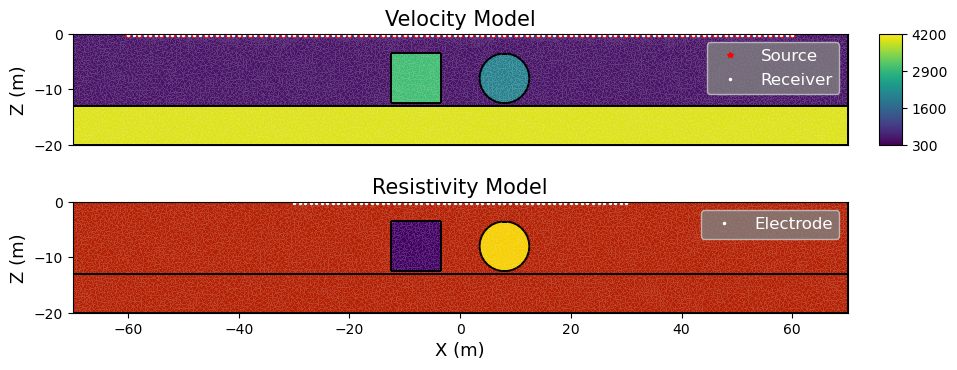

In [14]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,4))   
ax1.set_ylabel('Z (m)',fontsize=13)
ax2.set_ylabel('Z (m)',fontsize=13)
ax1.set_xticks([])
ax2.set_xlabel('X (m)',fontsize=13)
ax1.set_title('Velocity Model',fontsize=15)
ax2.set_title('Resistivity Model',fontsize=15)

# SRT
pg.show(tt_mesh, ax=ax1, data = vp, colorBar =False, logScale=False, cMap=c_srt, cMin=300, cMax=4200)
ax1.plot(TT_scheme.sensors()[::TT.dshot,0],TT_scheme.sensors()[::TT.dshot,1]-0.2, 'r*', markersize=4, label='Source')
ax1.plot(TT_scheme.sensors()[:,0],TT_scheme.sensors()[:,1]-0.2, 'w.', markersize=3, label='Receiver')

#ERT
pg.show(geom_mesh, ax=ax2, data = rhomap,colorBar =False,logScale=True,cMap=c_ert, cMin=50, cMax=10000)
ax2.plot(np.linspace(ERT.e_start,ERT.e_end,ERT.n_elecs)[::1],
        np.ones(len(np.linspace(ERT.e_start,ERT.e_end,ERT.n_elecs)[::1]))*(-0.2),'w.', markersize=3, label='Electrode')

ax1.legend(labelcolor='white', facecolor='gray', fontsize=12)
ax2.legend(labelcolor='white', facecolor='gray', fontsize=12)

# Colorbars
cax1 = ax1.inset_axes([1.04, 0, 0.03, 1])
createColorBarOnly(ax=cax1, cMin=300, cMax=4200, logScale=False,cMap=c_srt,nLevs=4,
                  label=pg.unit('vel'), orientation='vertical')

cax2 = ax2.inset_axes([1.04, 0, 0.03, 1])
createColorBarOnly(ax=cax2, cMin=50, cMax=10000, logScale=True,cMap=c_ert,nLevs=4,
                  label=pg.unit('res'), orientation='vertical')

# some axis edits
cax1.yaxis.label.set_size(13)
cax2.yaxis.label.set_size(13)
cax1.tick_params(labelsize=12)
cax2.tick_params(labelsize=12)
for axis in ax1,ax2:
    axis.tick_params(labelsize=12)

# plt.savefig(path+'Figures/Ch-3/Synth_models.pdf', bbox_inches='tight', dpi=600)

## Additional Figures

AttributeError: 'Colorbar' object has no attribute 'draw_all'

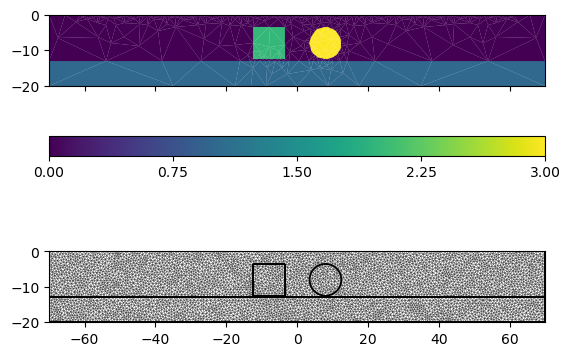

In [9]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, sharey=True)
pg.show(geom_mesh, ax=ax2)
pg.show(geom, ax=ax1, orientation='vertical')
ax1.set_title('Subsurface geometry')
ax2.set_title('Mesh')
ax1.set_ylabel('Z (m)')
ax2.set_ylabel('Z (m)')
ax1.set_xlabel('X (m)')
ax2.set_xlabel('X (m)')

# Inspecting refined mesh
fig, ax = plt.subplots(1,1)
pg.show(ert_mesh,ax=ax)
ax.plot(np.linspace(ERT.e_start,ERT.e_end,ERT.n_elecs)[::1],
        np.ones(len(np.linspace(ERT.e_start,ERT.e_end,ERT.n_elecs)[::1]))*0.2, 'b.')
ax.set_xlabel('Distance in m')
ax.set_ylim([-20,1])
ax.set_ylabel('Z (m)')
ax.set_xlabel('X (m)')

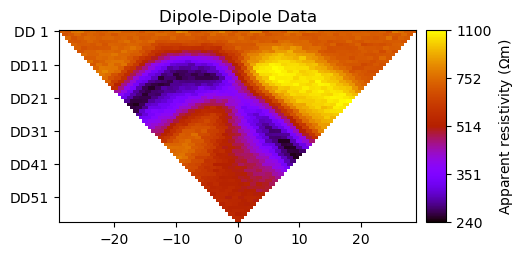

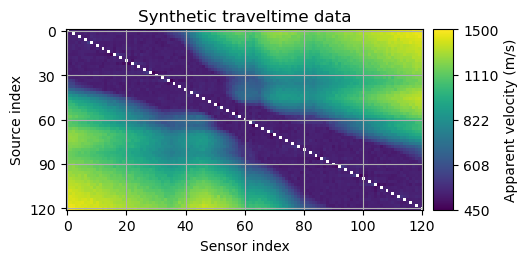

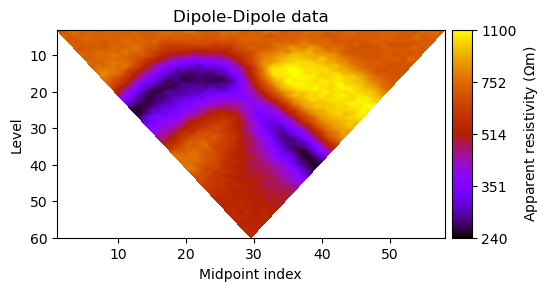

In [11]:
from    pygimli.viewer.mpl      import createColorBarOnly
lim = [round(min(ert_data['rhoa']), -1)-10, round(max(ert_data['rhoa']), -2)] # Pseudosection limits

%matplotlib inline

# Inspecting ERT data
fig, ax1 = plt.subplots(1, figsize=(5,2.5))     
ert.show(ert_data, ax=ax1, cMin=lim[0], cMax=lim[1], orientation='vertical', cMap=c_ert)
ax1.set_title('Dipole-Dipole Data')
# plt.savefig(path+'Figures/Ch-3/Synth_ert_data.pdf', bbox_inches='tight',dpi=600)

# Inspecting TT data
fig, ax = plt.subplots(1, figsize=(5,3))
mgr_tt.showData(tt_data,ax=ax,orientation="vertical", cMap=c_srt, cMin=450, cMax=1500)
ax.set_xlabel('Sensor index')
ax.set_ylabel('Source index')
ax.set_title('Synthetic traveltime data')
# plt.savefig(path+'Figures/Ch-3/Synth_srt_data.pdf', bbox_inches='tight',dpi=600)



fig, ax = plt.subplots(figsize=(5,2.7))
showPseudosections(ert_data, ert_data['rhoa'].array(), [0,len(ert_data['a'])], 1, ax=ax, cmap='gnuplot', clim=lim, annotation=False, colorBar=False)
ax.set_title('Dipole-Dipole data')

cax = ax.inset_axes([1.02, 0, 0.05, 1])
createColorBarOnly(ax=cax, cMin=lim[0], cMax=lim[1], logScale=True,cMap='gnuplot',
                              label=pg.unit('rhoa'), orientation='vertical')

# plt.savefig(path+'Figures/Ch-3/Synth_ert_data_own.png', bbox_inches='tight',dpi=600)